# DS106 Capstone Project : Introduction and Text Pre-Processing 

The aim of this project is to sieve out the underlying topics from unstructured text data (hotel reviews) followed by sentiment analysis of the reviews. The hotels that this project will focus on are budget hotels under the Ibis Singapore group. There are a total of 13 budget hotels under the Ibis Singapore brand. The reviews for the 13 budget hotels used in this project were scraped from TripAdvisor (code can be found in repo). 

The topic modelling and sentiment analysis of the data will be useful for hotel managers when it comes to identifying the pain points experienced by hotel guests, which increases the efficiency of their service recovery and improve the overall quality of the guests' experience. Good service quality and experience will usually lead to an increase in the number of repeat guests and attract new guests. This translates to higher revenue for the hotels. 

The hotel reviews will first be pre-processed for an unsupervised machine learning technique - Latent Dirichlet Allocation. The topics will then be extracted from LDA, which will be used to label the reviews. Sentiment analysis will also be conducted with TextBlob to get a sense of the sentiments for each topic. 

With the labelled reviews, supervised machine learning techniques will then be used to train a model to classify reviews into each of the topics. The model will then be used for deployment, where the hotel management can make use fo the model to classify a large number of reviews at one go, followed by sentiment analysis of the reviews. This can potentially allow the hotel management to make informed and timely decisions for service recovery and hotel quality improvement, thus attracting more guests and increasing revenue in the long run. 

**Flow of this project**

1. Import relevant libraries and dataset
2. Text pre-processing 
3. Topic Modelling using Latent Dirichlet Allocation
4. Sentiment Analysis using TextBlob
5. Exploratory Data Analysis
6. Topic Classification - Model Training 
7. Deployment 


## 1.  Import Relevant Libraries and Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns

sns.set_style('whitegrid')

import re
import string

import gensim
import gensim.downloader as api
import nltk
from cleantext import clean
from gensim.corpora.dictionary import Dictionary
from gensim.models.keyedvectors import KeyedVectors
from gensim.summarization import keywords
from gensim.test.utils import common_texts
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pylab import rcParams
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from wordcloud import WordCloud

#nltk.download('vader_lexicon')
import pickle
import unicodedata
import warnings

import contractions
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvi
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

warnings.filterwarnings('ignore')
import spacy
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()
from spacy.lang.en.stop_words import STOP_WORDS



Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [89]:
# Import dataset
df = pd.read_csv('ibis_budget_reviews.csv')
df

,Hotel_Name,Date,Title,Review,Rating
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3
...,...,...,...,...,...
5324,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",This hotel was located near Orchard road and m...,3
5325,ibis budget Singapore Selegie,September 2017,F1 weekend,Hotel is close to really good restaurants and ...,4
5326,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,"Beside the supper comfort, facilities and acco...",4
5327,ibis budget Singapore Selegie,October 2017,Worth it <3,Great place to stay! ^_^ Walking distance to m...,5


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hotel_Name  5329 non-null   object
 1   Date        5329 non-null   object
 2   Title       5329 non-null   object
 3   Review      5329 non-null   object
 4   Rating      5329 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 208.3+ KB


In [91]:
# Check if there are any duplicates 
df[df.duplicated(['Review'])]

,Hotel_Name,Date,Title,Review,Rating
240,ibis budget Singapore Pearl,October 2014,Ok and not ok plus advice,Ok : - price is ok /cheap for singapore standa...,4
241,ibis budget Singapore Pearl,August 2014,"Newly-renovated, budget, red light district hotel",It's newly-renovated so it's still quite clean...,3
242,ibis budget Singapore Pearl,September 2014,Clean Tidy Modern Budget Hotel,We stayed here as a transit stop on our way ho...,4
243,ibis budget Singapore Pearl,August 2014,Luxurious vacation in Singapore,We stayed in this hotel for 3 nights. The room...,4
244,ibis budget Singapore Pearl,August 2014,"Centrally located, good for one or two nights ...",The hotel is located in Geylang. The district ...,3
...,...,...,...,...,...
5324,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",This hotel was located near Orchard road and m...,3
5325,ibis budget Singapore Selegie,September 2017,F1 weekend,Hotel is close to really good restaurants and ...,4
5326,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,"Beside the supper comfort, facilities and acco...",4
5327,ibis budget Singapore Selegie,October 2017,Worth it <3,Great place to stay! ^_^ Walking distance to m...,5


In [92]:
# Drop duplicated reviews 
df.drop_duplicates(keep = 'first', inplace = True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3874 entries, 0 to 5278
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hotel_Name  3874 non-null   object
 1   Date        3874 non-null   object
 2   Title       3874 non-null   object
 3   Review      3874 non-null   object
 4   Rating      3874 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 181.6+ KB


Text(0.5, 1.0, 'Distribution of Ratings')

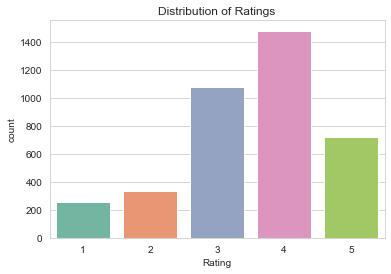

In [94]:
# Visualise the distribution of ratings given ny guests
sns.countplot(x = 'Rating', data= df, palette = 'Set2').set_title('Distribution of Ratings')

In [95]:
# Convert ratings to sentiments ( Positive, negative, neutral)
df['Ori_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

Text(0.5, 1.0, 'Distribution of Sentiments')

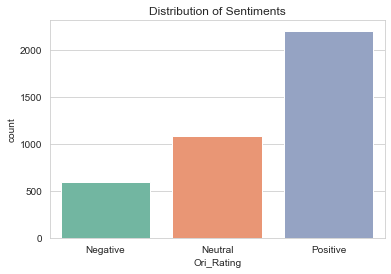

In [96]:
# Visualise the distribution of sentiments 
sns.countplot(x = 'Ori_Rating', data= df, palette = 'Set2').set_title('Distribution of Sentiments')

## 2. Text Pre-processing 

- To lower case
- Remove noise - punctuations, emoticons, accented words
- Expand contractions 
- Tokenisation
- Stopword Removal ( remove 'Not' from stopword bag)
- Stemming /lemmatization

In [97]:
# Loading list of stop words from NLTK
stop_words = set(stopwords.words('english'))

# Remove word 'not' in stopwords as Not can depict emotions
stop_words.remove('not')

In [98]:
# Create function to define and remove custom stopwords 
def remove_custom_stopwords(text):
    stopset = set(stopwords.words("english"))
    for word in ['via', 'etc','very', 'hotel', 'room', 'stay', 'square', 'would', 'also', 'singapore', 'clarke', 'quay','ibis', 'ruby', 'sapphire','fragrance']:
        stopset.add(word)
  
    text = ' '.join([word for word in text.split() if word not in stopset])
    return text


In [99]:
# Create a function to map Part of Speech tags to the tokens
def pos_tag_wordnet(tagged_tokens):
    tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
    new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
                            for word, tag in tagged_tokens]
    return new_tagged_tokens

In [100]:
# Create a function to process and clean texts 
def text_processing(review):
    
    #tokenize
    text = nltk.word_tokenize(review)
    
    #conver to lowercase 
    text = [t.lower() for t in text]
    
    # Remove all emoticons
    text = clean(text, no_emoji=True)
    
    # remove symbol
    text = [re.sub(r'^\d\w\s','',t) for t in text]
    
    #remove brackets
    text = [t.replace("(","").replace(")","") for t in text]
     
    # remove punctuation
    text = [t for t in text if t.isalnum()]
    
    # remove stopwords
    text  = [t for t in text if t not in  stop_words]
    
    #remove contractions
    text = [contractions.fix(t) for t in text]
    
    #Remove numbers
    text = [re.sub('\w*\d\w*', '', t) for t in text]
    
    #Remove ascii char
    text = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in text]
     
    #Remove empty tokens
    text = [t for t in text if t]
        
    #POS tagging
    text = nltk.pos_tag(text)
    text = pos_tag_wordnet(text)
    
    # Lemmatization
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(t,tag) for t,tag in text]
    
    #Join tokens
    text = ' '.join(text)
    
    return text
    

In [101]:
# Process and clean text
df['Cleaned_Review'] = df['Review'].apply(text_processing)
df

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget stay double room...
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,hotel not live expectation service standard ac...
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free room promotion double ro...
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest singapore fel...
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,ibis pearl good budget hotel geylang area room...
...,...,...,...,...,...,...,...
5274,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",This hotel was located near Orchard road and m...,3,Neutral,hotel locate near orchard road midway little i...
5275,ibis budget Singapore Selegie,September 2017,F1 weekend,Hotel is close to really good restaurants and ...,4,Positive,hotel close really good restaurant local shop ...
5276,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,"Beside the supper comfort, facilities and acco...",4,Positive,beside supper comfort facility accomodations h...
5277,ibis budget Singapore Selegie,October 2017,Worth it <3,Great place to stay! ^_^ Walking distance to m...,5,Positive,great place stay walk distance mustafa one rid...


In [102]:
#remove custom stopwords
df['Cleaned_Review'] = df['Cleaned_Review'].apply(remove_custom_stopwords)

In [103]:
df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...


In [104]:
df.to_csv('cleaned_reviews.csv', index = False)